In [1]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm

from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN
from prettytable import PrettyTable
from scipy.spatial.distance import cdist

In [2]:
import matplotlib.colors as colors
from itertools import cycle

def plotClustering(X, plt_labels):
    plt_colors = cycle(colors.cnames.keys())

    plt_K = np.unique(plt_labels).size

    for k in xrange(plt_K):
        color = plt_colors.next()
        mask = (plt_labels == k)
        plt.plot(X[mask, 0], X[mask, 1], 'w', markerfacecolor=color, marker='o')

    plt.show()

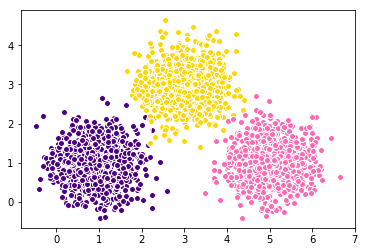

In [3]:
from sklearn import datasets

centers_ = [[1, 1], [3, 3], [5, 1]]
X_g, labels_g = datasets.make_blobs(n_samples=3000, n_features=2, centers=centers_, cluster_std=0.5)

plotClustering(X_g, labels_g)

iris = datasets.load_iris()
X_i = iris.data
Y_i = iris.target

## Task 0.

In [8]:
def get_clusters(X, Y):
    return [X[Y == i] for i in xrange(max(Y) + 1)]

def dunn_index(data, labels, centroids):
    clusters = get_clusters(data, labels)
    mx = np.amax(map(lambda c: np.amax(cdist(c, c)), clusters))
    
    d = cdist(centroids, centroids)
    mn = np.min(np.tril(np.full(d.shape, np.inf)) + np.triu(d))
    return mn / mx

def cluster_scatter(data, centroid, p=2):
    x = np.apply_along_axis(lambda r: np.linalg.norm(r), 1, (data-centroid)**p)
    x = (np.sum(x, axis=0) / data.shape[0]) ** (1.0 / p)
    return x

def measure_of_separation(c1, c2, p=2):
    return np.linalg.norm((c1 - c2), ord=p)

def db_index(data, labels, centroids):
    clusters = get_clusters(data, labels)
    s = np.zeros((len(clusters)))
    for i in np.arange(len(clusters)):
        s[i] = cluster_scatter(clusters[i], centroids[i])
        
    max_r = 0.0
    d = np.zeros((len(clusters)))
    for i in np.arange(len(clusters)):
        for j in np.arange(i, len(clusters)):
            if i != j:
                r = (s[i] + s[j]) / measure_of_separation(centroids[i], centroids[j])
                d[i] = max(r, d[i])
                
    return np.sum(d, axis=0) / (len(clusters))

def get_accuracy(X, predict_Y, centers):
    return [metrics.silhouette_score(X, predict_Y)] + (
        [db_index(X, predict_Y, centers), dunn_index(X, predict_Y, centers)]
        if centers is not None else [])

In [5]:
def plot_results(data, labels, centers, k):
#     cols = colors.cnames.keys()
    d = data.shape[1]
    fig, axes = plt.subplots(d, d)
    fig.subplots_adjust(left=0, right=2, top=2, bottom=0, hspace=.2, wspace=.2)
    subpl_num = 0
    
    for d1 in xrange(d):
        for d2 in xrange(d):
            subpl_num += 1
            if d1 != d2:
                plt.subplot(d, d, subpl_num)
                for c in np.arange(k):
                    its = labels == c
                    plt.scatter(data[its, d1], data[its, d2])
                no_group = labels == -1
                plt.scatter(data[no_group, d1], data[no_group, d2], marker='o', color='black')
    
                if centers is not None:
                    plt.scatter(centers[:, d1], centers[:, d2], marker='x')
        
    plt.show()

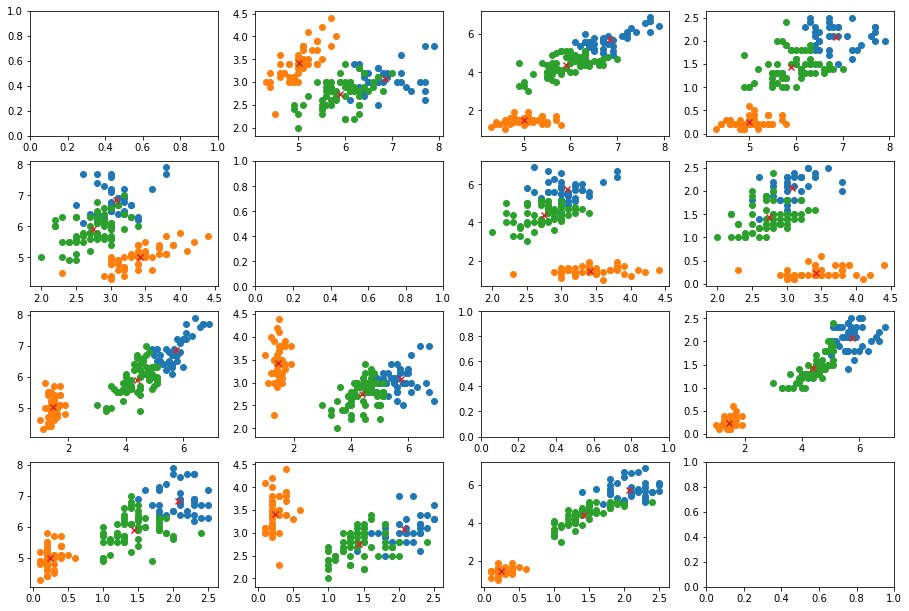

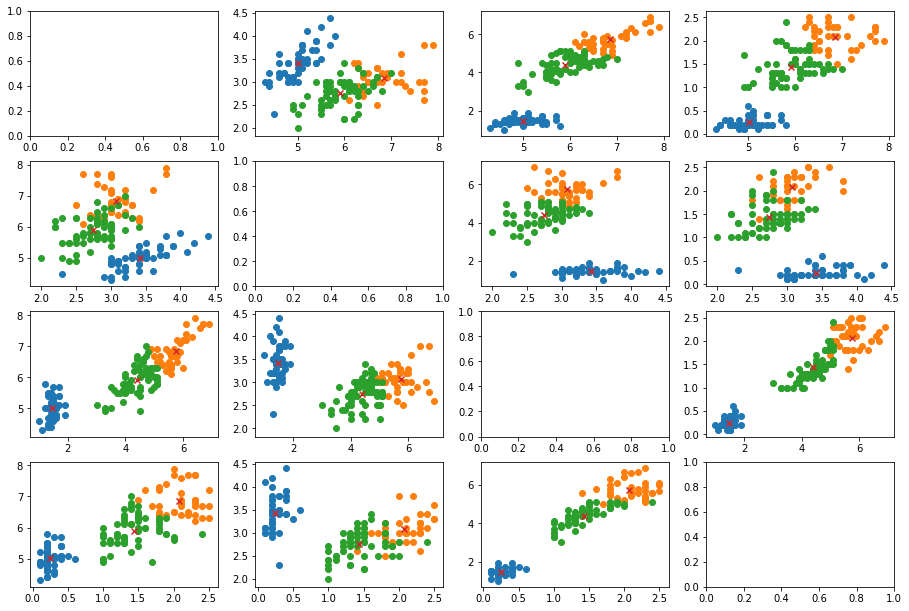

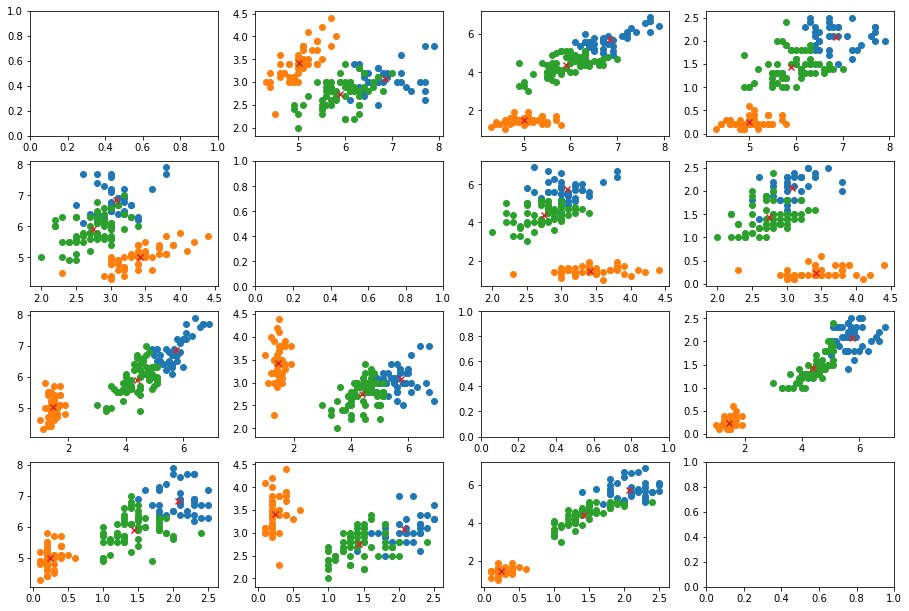

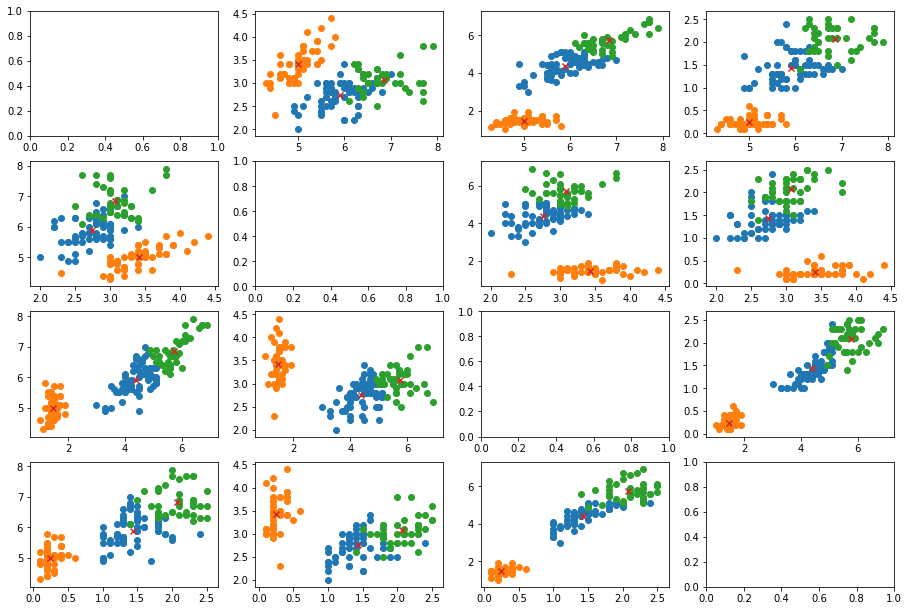

+--------+--------+----------------+----------------------+----------------+
|   name | n_init |     silhouette | davies-bouldin index |     dunn index |
+--------+--------+----------------+----------------------+----------------+
| clouds |     10 | 0.674175063518 |       0.308845570464 | 0.688994405125 |
| clouds |    300 | 0.674175063518 |       0.266121418023 | 0.688994405125 |
| clouds |    500 | 0.674175063518 |       0.308845570464 | 0.688994405125 |
| clouds |   1000 | 0.674175063518 |       0.266121418023 | 0.688994405125 |
|   iris |     10 | 0.552591944521 |       0.359017371273 | 0.671169841783 |
|   iris |    300 | 0.552591944521 |       0.359017371273 | 0.671169841783 |
|   iris |    500 | 0.552591944521 |       0.359017371273 | 0.671169841783 |
|   iris |   1000 | 0.552591944521 |       0.319946211983 | 0.671169841783 |
+--------+--------+----------------+----------------------+----------------+


In [93]:
## KMeans ## 

# n_init (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html): 
# Number of time the k-means algorithm will be run with different centroid seeds. 
# The final results will be the best output of n_init consecutive runs in terms of inertia.

t = PrettyTable(['name', 'n_init', 'silhouette', 'davies-bouldin index', 'dunn index'])
t.align = 'r'

for X, data in ((X_g, 'clouds'), (X_i, 'iris')): 
    for n_init in (10, 300, 500, 1000):
        k_means = KMeans(init='k-means++', n_clusters=3, n_init=n_init)
        k_means.fit(X)
    
        t.add_row([data, n_init] + get_accuracy(X, k_means.labels_, k_means.cluster_centers_))
        if data == 'iris':
            plot_results(X, k_means.labels_, k_means.cluster_centers_, 3)

print t

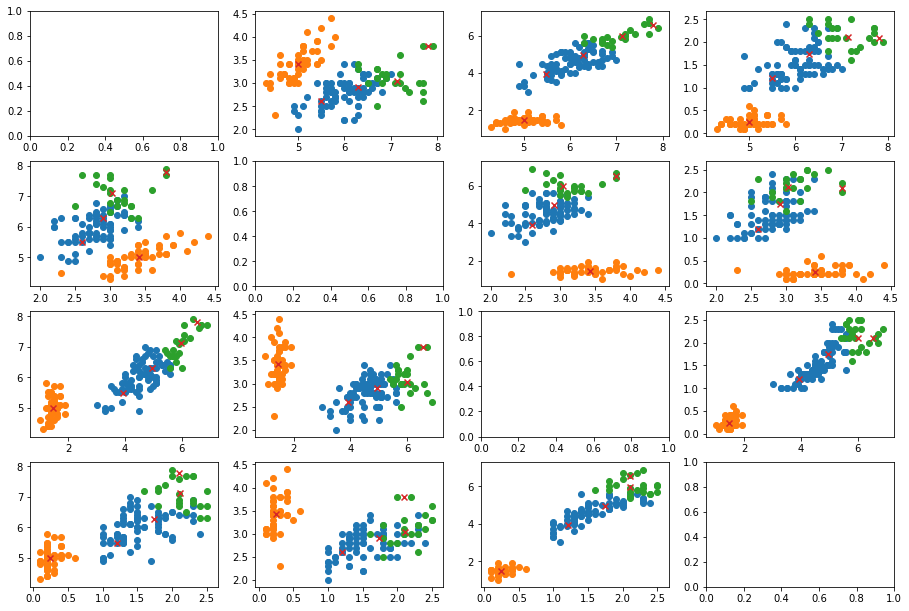

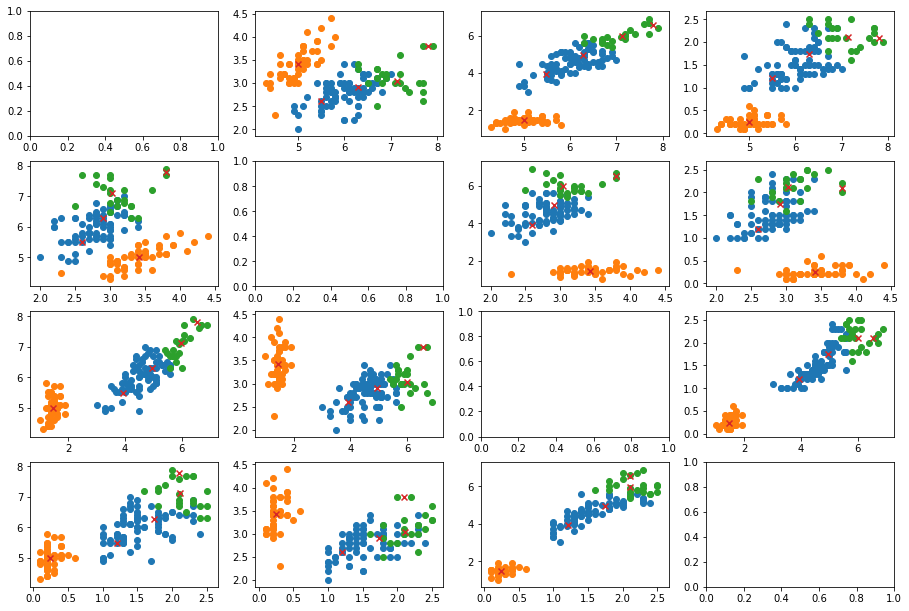

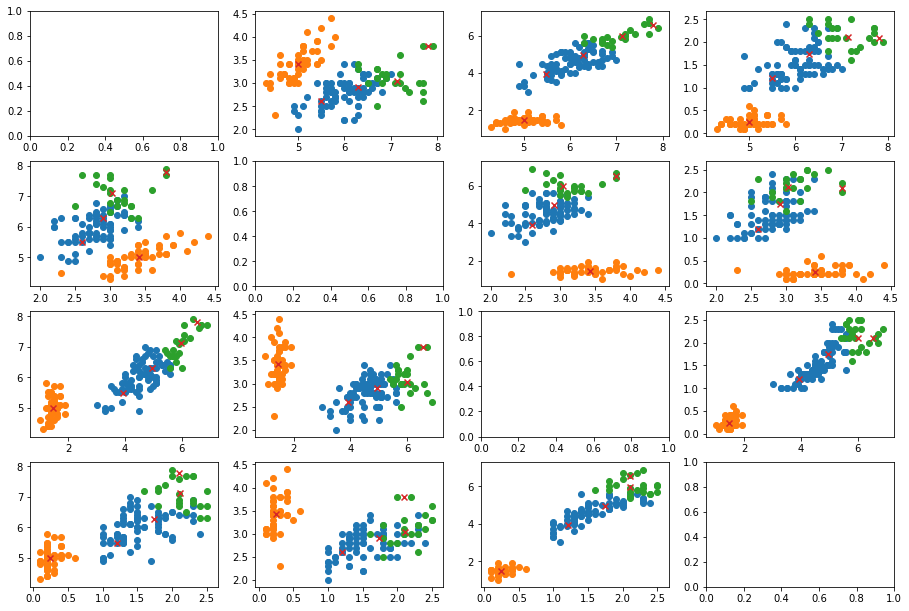

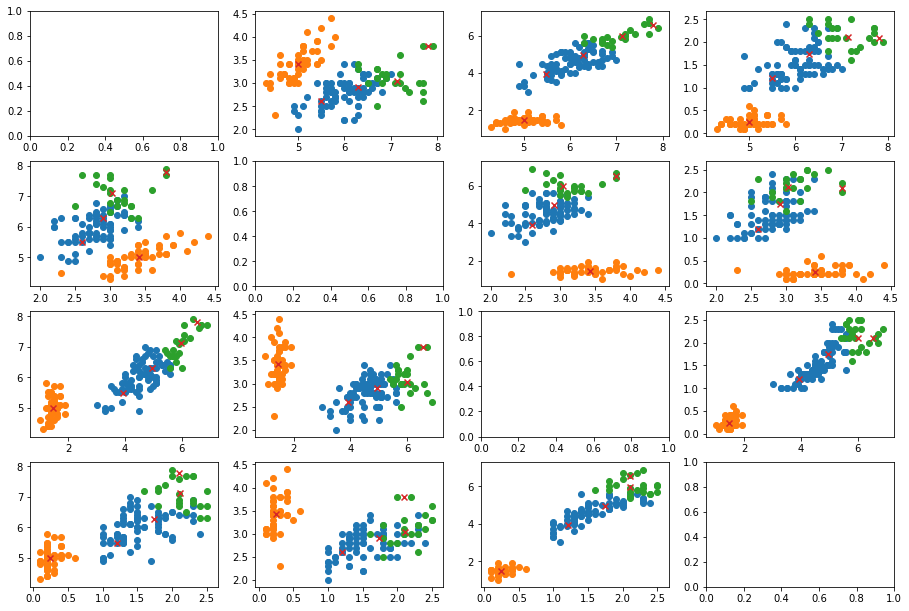

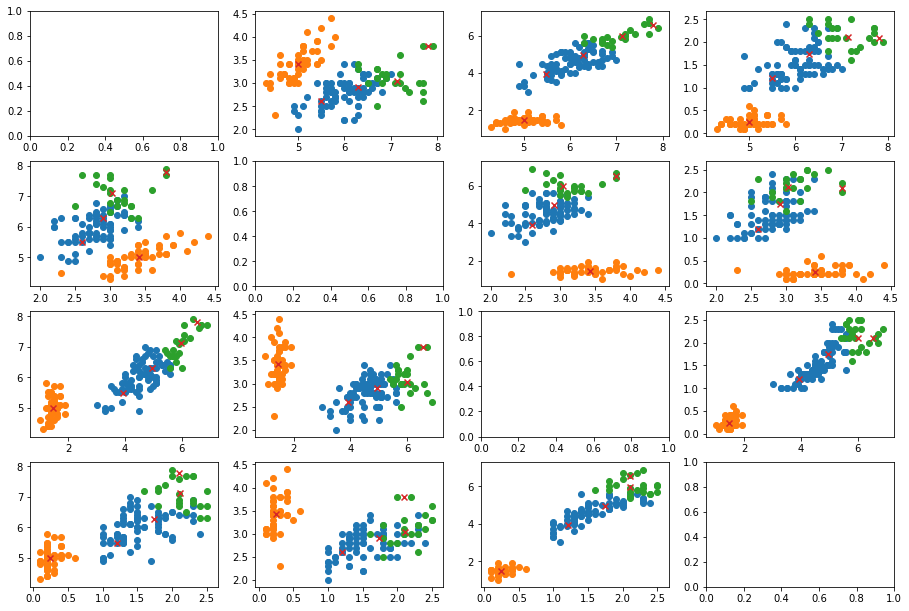

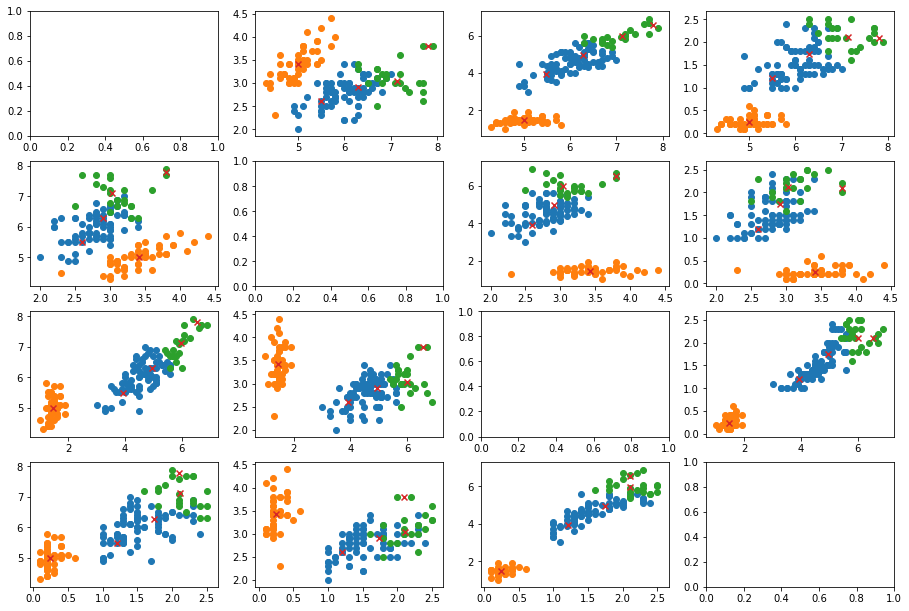

+--------+-----------+----------------+----------------------+----------------+
|   name | threshold |     silhouette | davies-bouldin index |     dunn index |
+--------+-----------+----------------+----------------------+----------------+
| clouds |      0.01 | 0.673817729864 |        1.42544806684 |  0.19562255538 |
| clouds |       0.1 | 0.673817729864 |        1.42544806684 |  0.19562255538 |
| clouds |       0.5 | 0.673817729864 |        1.42544806684 |  0.19562255538 |
| clouds |      0.75 | 0.673817729864 |        1.42544806684 |  0.19562255538 |
| clouds |       2.0 | 0.673817729864 |        1.42544806684 |  0.19562255538 |
| clouds |      10.0 | 0.673817729864 |        1.42544806684 |  0.19562255538 |
|   iris |      0.01 | 0.535269177603 |        2.02520741147 | 0.371222134955 |
|   iris |       0.1 | 0.535269177603 |        2.02520741147 | 0.371222134955 |
|   iris |       0.5 | 0.535269177603 |        2.02520741147 | 0.371222134955 |
|   iris |      0.75 | 0.535269177603 | 

In [94]:
## Birch ## 

t = PrettyTable(['name', 'threshold', 'silhouette', 'davies-bouldin index', 'dunn index'])
t.align = 'r'

# threshold : float, default 0.5
# The radius of the subcluster obtained by merging a new sample 
# and the closest subcluster should be lesser than the threshold. 
# Otherwise a new subcluster is started. 

for X, data in ((X_g, 'clouds'), (X_i, 'iris')): 
    for thr in (0.01, 0.1, 0.5, 0.75, 2.0, 10.0):
        birch = Birch(threshold=0.75, n_clusters=3)
        birch.fit(X)
        
        t.add_row([data, thr] + get_accuracy(X, birch.labels_, birch.subcluster_centers_))
        if data == 'iris':
            plot_results(X, birch.labels_, birch.subcluster_centers_, 3)

print t

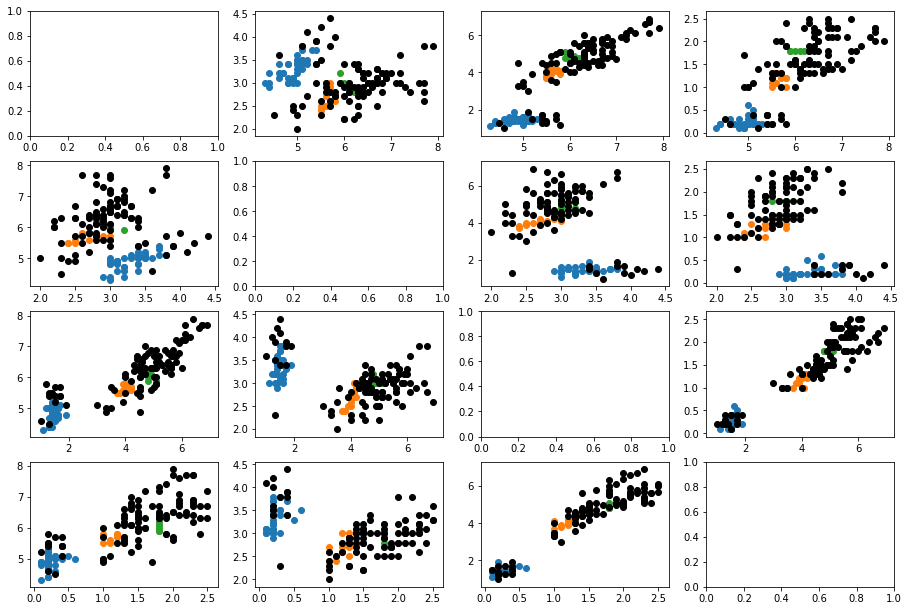

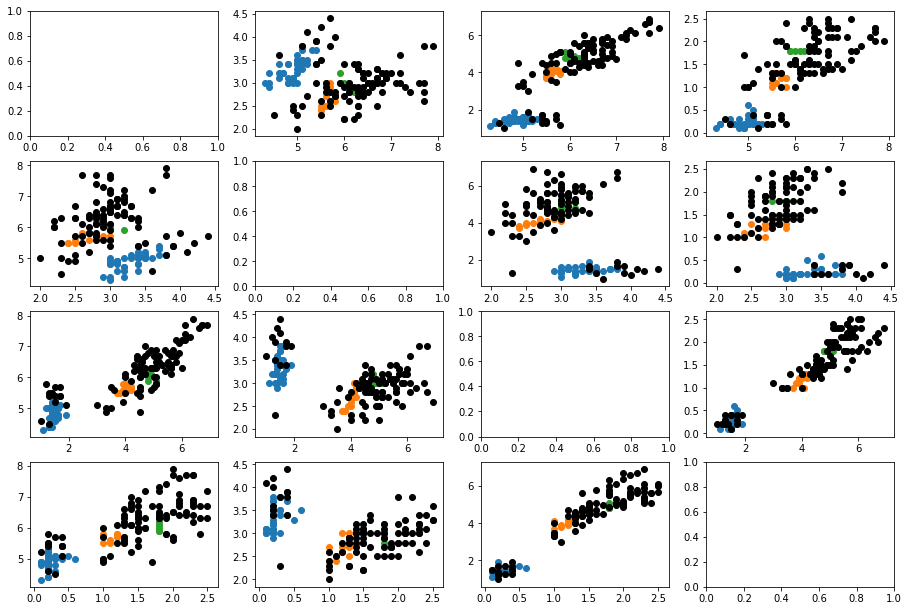

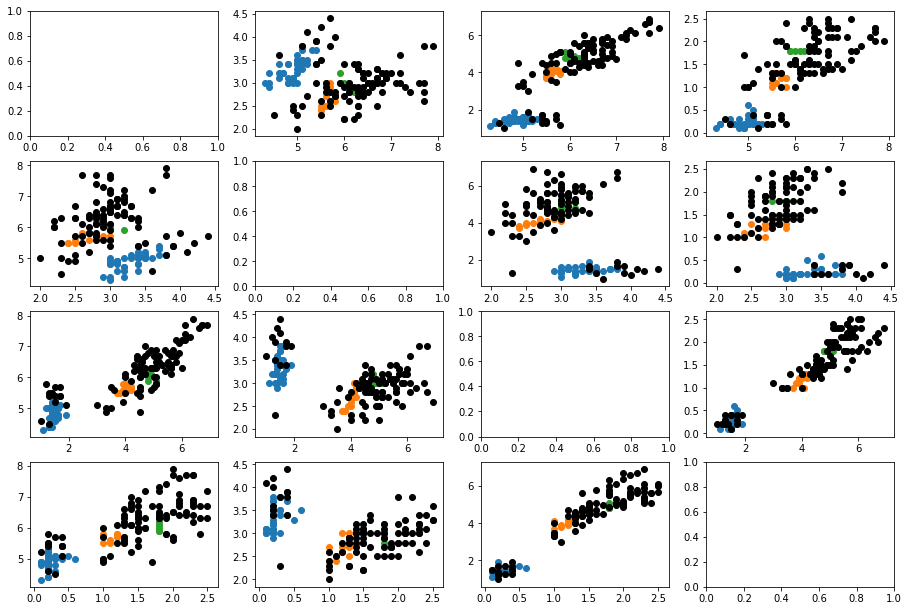

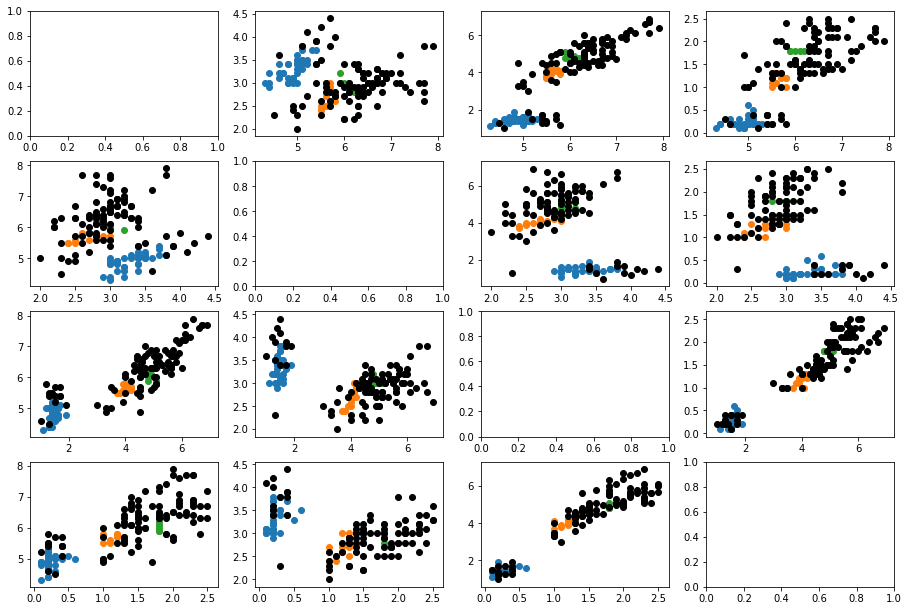

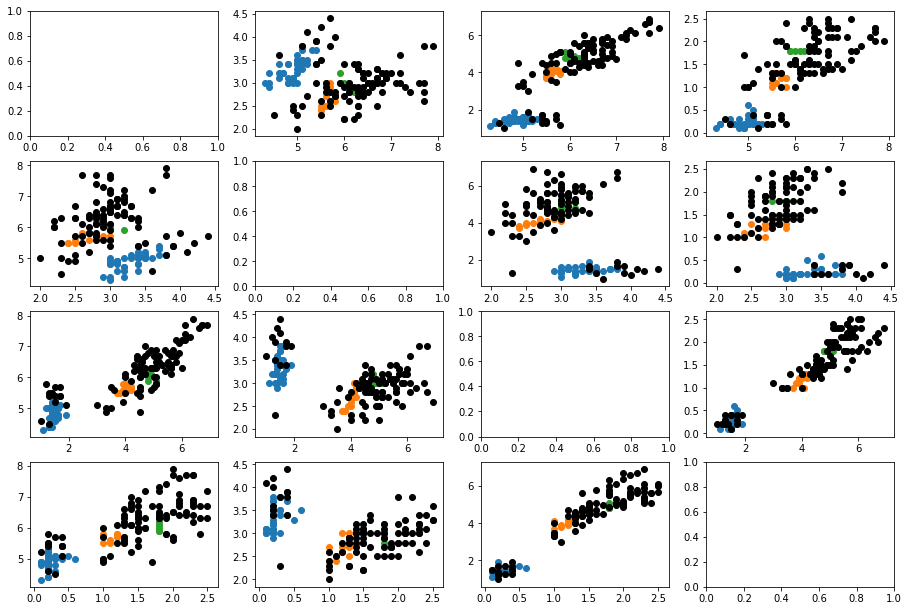

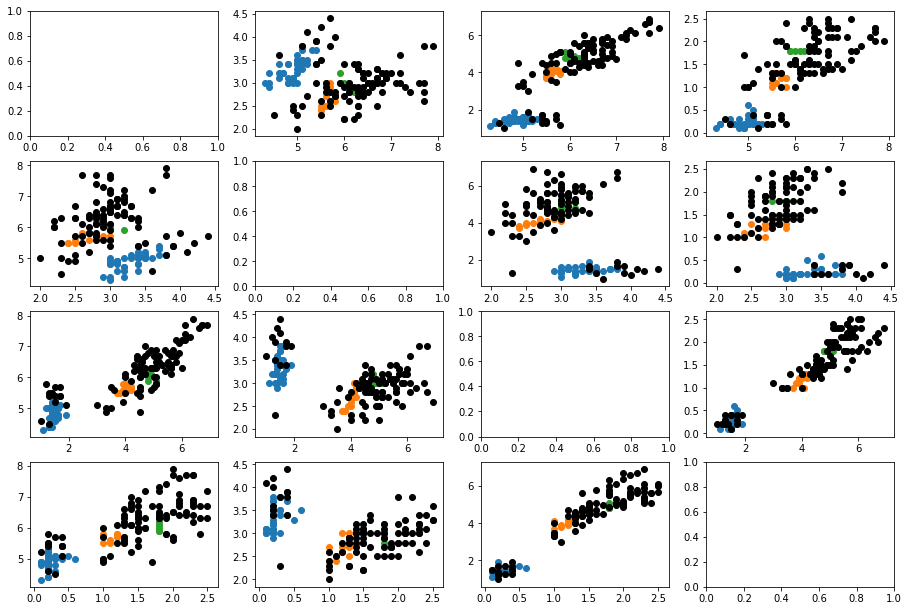

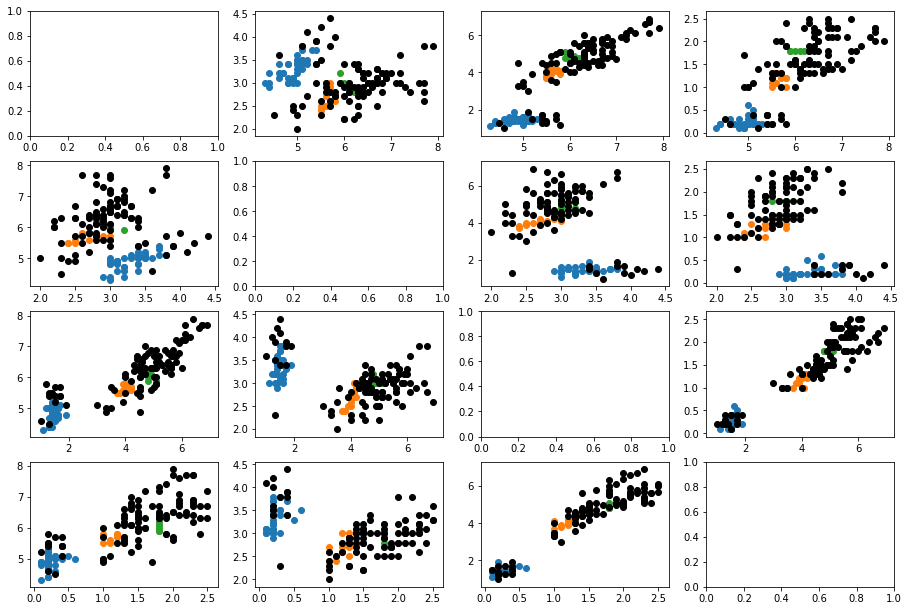

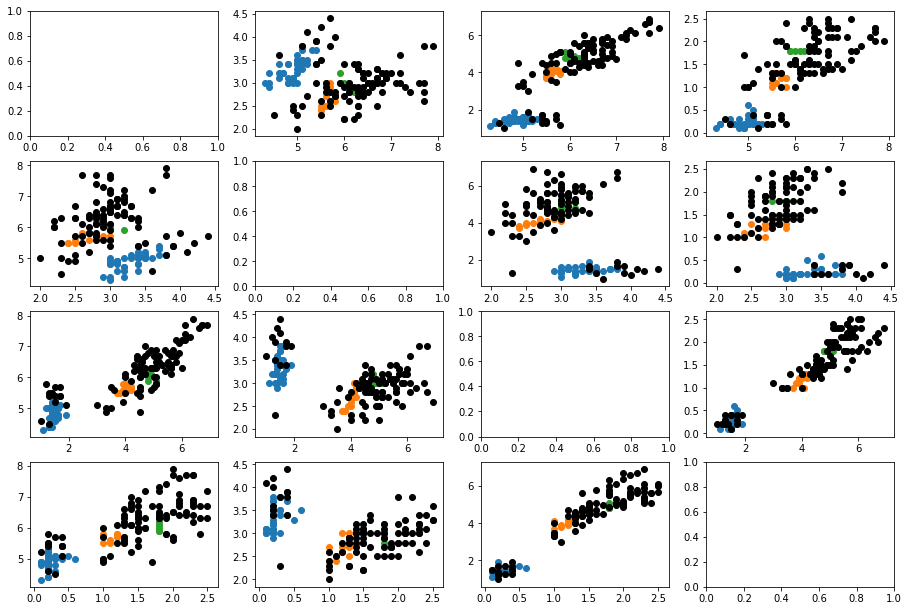

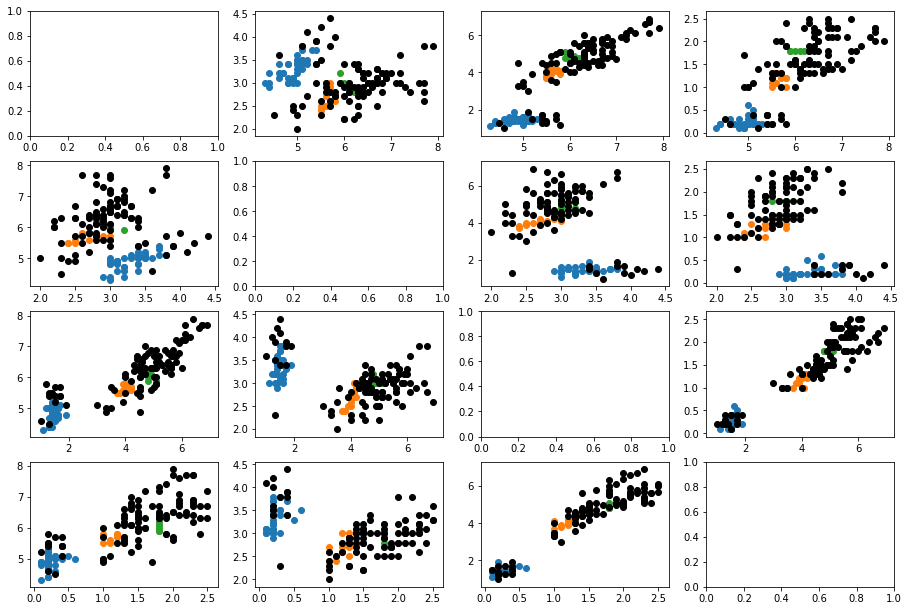

+--------+-------+------------------+
|   name |   eps |       silhouette |
+--------+-------+------------------+
|   iris | 0.001 | -0.0518387287002 |
|   iris |  0.01 | -0.0518387287002 |
|   iris |   0.1 | -0.0518387287002 |
|   iris |   0.2 | -0.0518387287002 |
|   iris |   0.3 | -0.0518387287002 |
|   iris |  0.75 | -0.0518387287002 |
|   iris |   1.0 | -0.0518387287002 |
|   iris |   2.5 | -0.0518387287002 |
|   iris |  10.0 | -0.0518387287002 |
| clouds | 0.001 |    0.20556608232 |
| clouds |  0.01 |    0.20556608232 |
| clouds |   0.1 |    0.20556608232 |
| clouds |   0.2 |    0.20556608232 |
| clouds |   0.3 |    0.20556608232 |
| clouds |  0.75 |    0.20556608232 |
| clouds |   1.0 |    0.20556608232 |
| clouds |   2.5 |    0.20556608232 |
| clouds |  10.0 |    0.20556608232 |
+--------+-------+------------------+


In [95]:
## DBScan ## 

# eps : float, optional
# The maximum distance between two samples for them to be considered as in the same neighborhood.

t = PrettyTable(['name', 'eps', 'silhouette'])
t.align = 'r'

for X, data in ((X_i, 'iris'), (X_g, 'clouds')): 
    for eps in (0.001, 0.01, 0.1, 0.2, 0.3, 0.75, 1.0, 2.5, 10.0):
        dbscan = DBSCAN(eps=0.3)
        dbscan.fit(X)
        
        t.add_row([data, eps] + get_accuracy(X, dbscan.labels_, None))
        if data == 'iris':
            plot_results(X, dbscan.labels_, None, 3)

print t

## Task 1.

[0.20974107907427247, 0.4682451771536798, 0.45682697354787571]


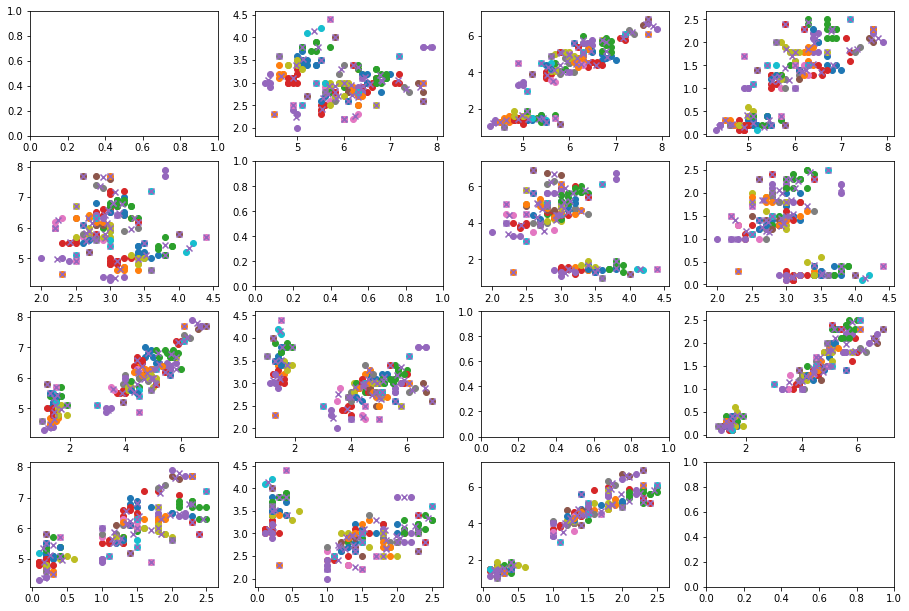

In [9]:
birch = Birch(threshold=0.25, n_clusters=None)
birch.fit(X_i)

print get_accuracy(X_i, birch.labels_, birch.subcluster_centers_)
plot_results(X_i, birch.labels_, birch.subcluster_centers_, max(birch.labels_) + 1)

In [98]:
print birch.root_, birch.root_.centroids_

<sklearn.cluster.birch._CFNode object at 0x7f8cf19e4890> [[ 5.15142857  3.18428571  2.13285714  0.50857143]
 [ 6.44875     2.94        5.18125     1.8025    ]]
